# 1. Setup environment

## 1.1 Install dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplolib

## 1.2 Import dependencies

In [1]:
import numpy as np
import os
import pathlib

import matplotlib.pyplot as plt
from matplotlib import patches
# from matplotlib.collections import PatchCollection
# from matplotlib import cm
# from matplotlib import animation

# Import uuid library to generate unique image names
# import uuid

In [2]:
# Importing Tensorflow - Funcitonal API
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization
# Import Metric calculation
from tensorflow.keras.metrics import Precision, Recall
#
import tensorflow as tf
# Tensorflow Datasets
# import tensorflow_datasets as tfds

# np.set_printoptions(precision=8)
# tf.keras.backend.set_floatx('float64')


2023-06-25 20:35:33.827439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 20:35:33.929674: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-25 20:35:34.406237: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPIT/lib64:/usr/local/cuda/lib64:/home/paco/miniconda3/envs/tf/

## 1.3 Limit GPU growth

In [3]:
# Avoid Out of Memory (OOM) errors by setting GPU Memory Consuption Growth
# Without this, by default tensorflow uses all memory available
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
# Print Tensorflow version and GPU available
print("Tensorflow Version: {}".format(tf.__version__))
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))

Tensorflow Version: 2.11.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-25 20:35:35.449715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 20:35:35.459392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 20:35:35.459535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 20:35:35.461428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 20:35:35.461565: I tensorflow/compiler/xla/stream_executo

# 2. Load and preprocess Dataset

## 2.1 Get training image paths

In [4]:
# Create a Tensorflow Dataset through list_files
dataset_dir = tf.data.Dataset.list_files('dataset/*.jpg', shuffle=True)

In [5]:
# Look one sample
dir_test = dataset_dir.as_numpy_iterator()
dir_test.next()

b'dataset/img002965.jpg'

## 2.2 Define a preprocessing function

In [6]:
# Define a function to load the image and resize it and its label (ground truth)
@tf.function
def preprocess_path_rgb(file_path):
    '''
    Function that converts a file path to a normalized `(img, [xc, yc, r])` pair:
    '''
    # Get coordinates (xc, yc, radius) from annotation file
    annotation_file = tf.strings.regex_replace(file_path, ".jpg", ".txt", replace_global=True, name=None)
    # Read annotation file
    y_true = tf.io.read_file(annotation_file)
    # Take all until -2
    y_true = tf.strings.substr(y_true, 0, 32)
    # Decode as columns (already normalized)
    y_true = tf.io.decode_csv(y_true, record_defaults=[np.float64(), np.float64(), np.float64()], field_delim=',')
    #
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size of 100x100x3
    img = tf.image.resize(img, [200, 200])
    # Scaling image to be between 0 and 1
    img = img / 255.0
    
    # Return the image
    return img, y_true

Text(0, 0.5, 'yc = 69')

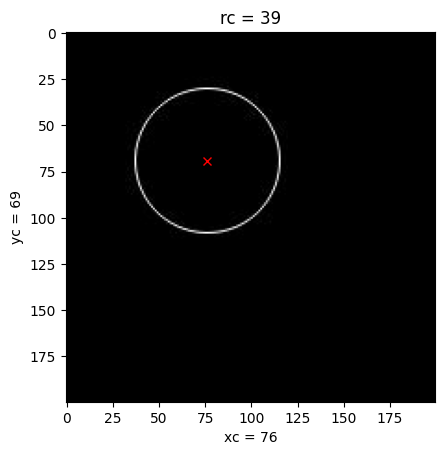

In [17]:
# Network Image Size
net_img_size = 200
# Plot an example
sample = preprocess_path_rgb(dir_test.next())
plt.imshow(sample[0])
plt.plot(int(sample[1][0] * net_img_size), int(sample[1][1] * net_img_size), 'rx')
plt.title(f'rc = {int(sample[1][2] * net_img_size)}')
plt.xlabel(f'xc = {int(sample[1][0] * net_img_size)}')
plt.ylabel(f'yc = {int(sample[1][1] * net_img_size)}')

## 2.3 Create labelled dataset

In [8]:
# Build pipeline
dataset = dataset_dir.map(preprocess_path_rgb)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1024)

## 2.4 Build train and test partition

In [9]:
# Training partition 70%
split_100 = 0.7
train_partition = dataset.take(round(len(dataset_dir) * split_100))
# train_data = dataset.take(round(len(dataset_dir) * split_100))
# train_data = train_data.batch(16)
# train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE) # 8)                      

In [10]:
# Testing partition 30%
test_data = dataset.skip(round(len(dataset_dir) * split_100))
test_data = test_data.take(round(len(dataset_dir) * (1-split_100)))
test_data = test_data.batch(16)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE) # 8)                      

In [11]:
# This partition will be 80% for training and 20% for validation
split_train_100 = 0.8
train_data = train_partition.take(round(len(train_partition) * split_train_100))
train_data = train_data.batch(16)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE) # 8)
# Validation data
validation_data = train_partition.skip(round(len(train_partition) * split_train_100))
validation_data = validation_data.take(round(len(train_partition) * (1-split_train_100)))
validation_data = validation_data.batch(16)
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE) # 8)                      

# 3. Model Creation

## 3.1 Structure

In [12]:
def uncompiled_model():
    # Input
    inp = keras.Input(shape=(200, 200, 3), name="input_image")  # 200x200x3 RGB images
    #
    # ===========================================
    # Backbone - Feature Extractions - Classifier
    # ===========================================
    # First Block
    c1  = Conv2D(64, (10, 10), activation='relu')(inp)
    bn1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(c1)
    m1  = MaxPooling2D(64, (2, 2), padding='same')(c1)
    # Second Block
    c2  = Conv2D(128, (7, 7), activation='relu')(m1)
    bn2 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(c2)
    m2  = MaxPooling2D(64, (2, 2), padding='same')(c2)
    # Third Block
    c3  = Conv2D(128, (4, 4), activation='relu')(m2)
    bn3 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(c3)
    m3  = MaxPooling2D(64, (2, 2), padding='same')(c3)
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    backbone = Flatten()(c4)
    #
    # # Time to apply global max pooling.
    # backbone = layers.GlobalMaxPooling2D()(backbone)
    #
    # # Flatten
    # backbone = layers.Flatten()(d1)
    #
    # ===================================
    # Head - Circle parameters Regression
    # ===================================
    d1 = Dense(1024, activation='linear', name="head_fc1")(backbone)
    d2 = Dense(1024, activation="relu", name="head_fc2")(d1)
    # d3 = layers.Dense(512, activation="relu", name="head_fc2")(d2)
    # head = layers.Dropout(0.4, name="head_dropout1")(head)
    # head = layers.Dense(128, activation="relu", name="head_fc3")(head)
    out  = Dense(3, activation="linear", name="head_predictions")(d2)  # , kernel_regularizer='l1_l2', name="head_predictions")(head)
    #
    # Generate and return the model
    model = keras.Model(inputs=[inp], outputs=[out], name="circle_estimator")
    return model

In [13]:
model = uncompiled_model()
model.summary()

Model: "circle_estimator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 191, 191, 64)      19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 128)  

# 4. Training

## 4.1 Compile Model - Setup Loss and Optimizer

In [27]:
# Define optimizer
model_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Define Loss
model_loss = tf.keras.losses.MeanSquaredError() # reduction='sum_over_batch_size')

In [28]:
# Compile
model.compile(
    optimizer=model_opt,
    # Loss function to minimize
    loss=model_loss,
    # List of metrics to monitor
    # metrics=[keras.metrics.Accuracy()],
    metrics=['accuracy']
)

## 4.2 Establish Checkpoints

In [36]:
checkpoint_dir = './training_checkpoints/'
# checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
# checkpoint = tf.train.Checkpoint(optimizer=model_opt, model=model)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=False,
    save_freq=len(train_data), #save_frequency_in_batch, #'epoch',
    verbose=1
)

## 4.3 Train the model

In [43]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    batch_size=16,
    verbose=2,
    shuffle=True,
    epochs=5,
    callbacks=[cp_callback]  # Pass callback to training
)

Epoch 1/5


2023-06-25 22:20:40.880390: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 1: saving model to ./training_checkpoints/


2023-06-25 22:20:47.982006: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 - 64s - loss: 2.2378e-04 - accuracy: 0.9661 - val_loss: 2.0973e-04 - val_accuracy: 0.9800 - 64s/epoch - 365ms/step
Epoch 2/5


2023-06-25 22:21:43.726204: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 2: saving model to ./training_checkpoints/


2023-06-25 22:21:50.924663: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 - 63s - loss: 2.5554e-04 - accuracy: 0.9729 - val_loss: 5.3791e-04 - val_accuracy: 0.9286 - 63s/epoch - 360ms/step
Epoch 3/5


2023-06-25 22:22:47.063356: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 3: saving model to ./training_checkpoints/


2023-06-25 22:22:54.694785: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 - 64s - loss: 2.6466e-04 - accuracy: 0.9718 - val_loss: 1.5410e-04 - val_accuracy: 0.9843 - 64s/epoch - 364ms/step
Epoch 4/5


2023-06-25 22:23:51.565871: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 4: saving model to ./training_checkpoints/


2023-06-25 22:23:59.096828: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 - 64s - loss: 1.6341e-04 - accuracy: 0.9739 - val_loss: 1.4334e-04 - val_accuracy: 0.9771 - 64s/epoch - 368ms/step
Epoch 5/5


2023-06-25 22:24:56.922080: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 5: saving model to ./training_checkpoints/


2023-06-25 22:25:04.348447: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 - 65s - loss: 1.8995e-04 - accuracy: 0.9739 - val_loss: 1.6720e-04 - val_accuracy: 0.9714 - 65s/epoch - 373ms/step


In [44]:
# Get a batch of test data
test_input, y_true = test_data.as_numpy_iterator().next()

2023-06-25 22:39:00.381423: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [52]:
# Make predictions
y_hat = model.predict([test_input])
y_hat

1/1 [==============================] - 0s 24ms/step


array([[0.34821495, 0.5141094 , 0.12526548],
       [0.4207026 , 0.33460122, 0.2714746 ],
       [0.40634146, 0.48803696, 0.38344646],
       [0.9119948 , 0.5566798 , 0.1213524 ],
       [0.4993308 , 0.2905802 , 0.18135412],
       [0.4934816 , 0.7285701 , 0.13754229],
       [0.6877374 , 0.6487005 , 0.2120558 ],
       [0.43780285, 0.76007414, 0.17222689],
       [0.8110775 , 0.8250936 , 0.10814936],
       [0.67939   , 0.34958726, 0.27383476],
       [0.21073818, 0.43696028, 0.14881341],
       [0.5065144 , 0.597391  , 0.3118423 ],
       [0.8595944 , 0.37653098, 0.14532244],
       [0.39021412, 0.4623221 , 0.2060057 ],
       [0.45141077, 0.6518455 , 0.32239518],
       [0.7002331 , 0.6225717 , 0.2377659 ]], dtype=float32)

In [53]:
y_true

array([[0.335, 0.51 , 0.13 ],
       [0.42 , 0.32 , 0.265],
       [0.41 , 0.46 , 0.385],
       [0.875, 0.57 , 0.11 ],
       [0.495, 0.28 , 0.185],
       [0.53 , 0.725, 0.15 ],
       [0.685, 0.65 , 0.215],
       [0.44 , 0.755, 0.18 ],
       [0.835, 0.855, 0.11 ],
       [0.68 , 0.33 , 0.275],
       [0.205, 0.45 , 0.15 ],
       [0.525, 0.58 , 0.32 ],
       [0.84 , 0.375, 0.135],
       [0.39 , 0.445, 0.21 ],
       [0.47 , 0.64 , 0.33 ],
       [0.7  , 0.615, 0.25 ]])

In [54]:
# Creating a metric object
m = Recall()

# Calculate the recall values
m.update_state(y_true, y_hat)

# View the results
m.result().numpy()

0.33333334

In [55]:
# Creating a metric object
m = Precision()

# Calculate the recall values
m.update_state(y_true, y_hat)

# View the results
m.result().numpy()

1.0

# 7. Save model

In [50]:
# Save weights
model.save('circle_estimator_model_200x200x3.h5')

In [51]:
# Reload model for testing
model1 = tf.keras.models.load_model('circle_estimator_model_200x200x3.h5')